# Statistical Analysis: Genius Song Lyrics Subset (1%)

**Dataset:** 51'349 Songs | 5'333 Artists | 6 Genres

**Purpose:** Explore patterns and distributions in song lyrics across genres and artists. Focus on word frequencies, stylistic differences and similarity structures.

---

# 1. Dataset Overview
## 1.1 Import Packages and Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

## 1.2 Load Dataset

In [3]:
df = pd.read_csv('data/clean/lyrics_subset_1pct_clean.csv')

print(f"DataFrame shape: {df.shape}")
print(f"Number of Songs: {len(df)} | Artists: {df['artist'].nunique()}")
df.head()

DataFrame shape: (51348, 11)
Number of Songs: 51348 | Artists: 39461


,title,tag,artist,year,views,features,id,language_cld3,language_ft,language,lyrics
0,2 Is Better 棍子,rap,Chris Travis,2017,4437,{},3036329,en,en,en,Bitch I'm clean Two sticks like Chow Mein Two ...
1,Scottie,rap,KrJ,2012,89,{},72180,en,en,en,My old girl left me on her old bull shit So I ...
2,Pirate Password,rock,The never land pirate band,2011,175,{},2122100,en,en,en,Avast there matey haha If a pirate asks ya for...
3,Indri,rock,Puta Volcano,2015,14,{},6889288,en,en,en,Just throw a glimpse under the shell Ghostly v...
4,Maps,misc,ANBARDA,2018,4,{},3735887,en,en,en,I miss the taste of a sweeter life I miss the ...


## 1.3 Descriptive Statistics

In [4]:
# Genre distribution
print("\nGENRE DISTRIBUTION")
print("=" * 60)
category_counts = df['tag'].value_counts().sort_values(ascending=False)

for tag,count in category_counts.items():
    pct = (count / len(df)) * 100
    print(f"{tag}: {count:,} songs ({pct:.2f}%)")


GENRE DISTRIBUTION
pop: 21,438 songs (41.75%)
rap: 17,175 songs (33.45%)
rock: 8,001 songs (15.58%)
rb: 1,894 songs (3.69%)
misc: 1,860 songs (3.62%)
country: 980 songs (1.91%)


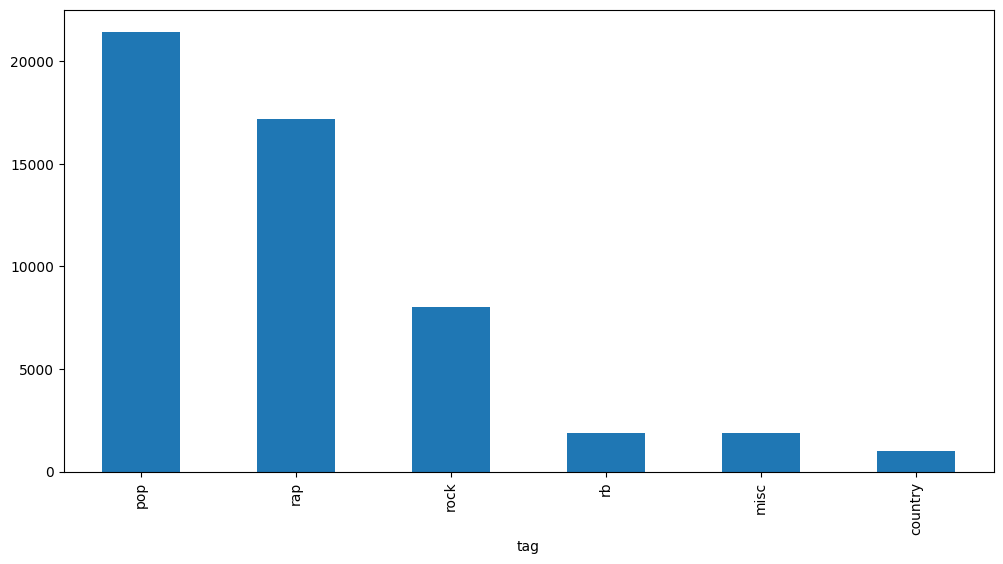

In [5]:
category_counts.plot(kind="bar")
plt.show()